# Лабораторная работа: Поиск и сопоставление ключевых точек

## Цель работы
Реализовать алгоритм поиска и сопоставления ключевых точек с предварительной обработкой изображений.

## Задачи
1. Получение изображений с разных ракурсов
2. Шумоподавление (3 фильтра)
3. Коррекция гистограммы
4. Гамма-коррекция
5. Коррекция геометрических искажений (калибровка камеры)
6. Поиск ключевых точек (топ-200)
7. Сопоставление ключевых точек (не более 5% ошибок)

## 1. Импорт библиотек и настройка окружения

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import pillow_heif

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

def show_images(images, titles, cmap='gray', cols=3):
    n = len(images)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if n == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n > cols else axes
    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 3 and img.shape[2] == 3:
            axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis('off')
    for i in range(n, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

def load_heic(path):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"Файл не найден: {os.path.abspath(path)}")
    heif_file = pillow_heif.read_heif(path)
    image = heif_file.to_pillow()
    if image.mode != "RGB":
        image = image.convert("RGB")
    img_rgb = np.array(image)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    return img_bgr

def load_image(path):
    if path.lower().endswith('.heic') or path.lower().endswith('.heif'):
        return load_heic(path)
    else:
        img = cv2.imread(path)
        if img is None:
            raise FileNotFoundError(f"Не удалось загрузить изображение: {path}")
        return img

print("Библиотеки успешно импортированы!")
print(f"OpenCV версия: {cv2.__version__}")

Библиотеки успешно импортированы!
OpenCV версия: 4.12.0


## 2. Загрузка изображений

Загружаем два изображения одного объекта с разных ракурсов (радиальное смещение 5-10° в горизонтальной плоскости).

✓ Загружено: (4000, 3000, 3) (4000, 3000, 3)


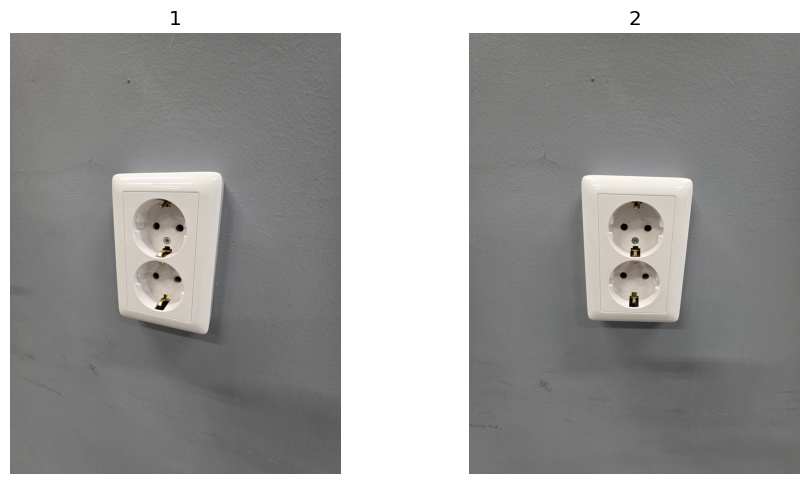

In [2]:
image1_path = 'img/roz3.heic'
image2_path = 'img/roz2.heic'

try:
    img1_original = load_image(image1_path)
    img2_original = load_image(image2_path)
    print("✓ Загружено:", img1_original.shape, img2_original.shape)
    show_images([img1_original, img2_original], ['1', '2'], cols=2)
except FileNotFoundError as e:
    print("Файл не найден:", e)
    print("PWD:", os.getcwd())
    print("1:", os.path.abspath(image1_path))
    print("2:", os.path.abspath(image2_path))
except Exception as e:
    print("Ошибка:", e)
    import traceback
    traceback.print_exc()

## 3. Шумоподавление

Применяем три различных фильтра для шумоподавления:
1. **Гауссовский фильтр** (Gaussian Blur)
2. **Медианный фильтр** (Median Blur)
3. **Билатеральный фильтр** (Bilateral Filter)

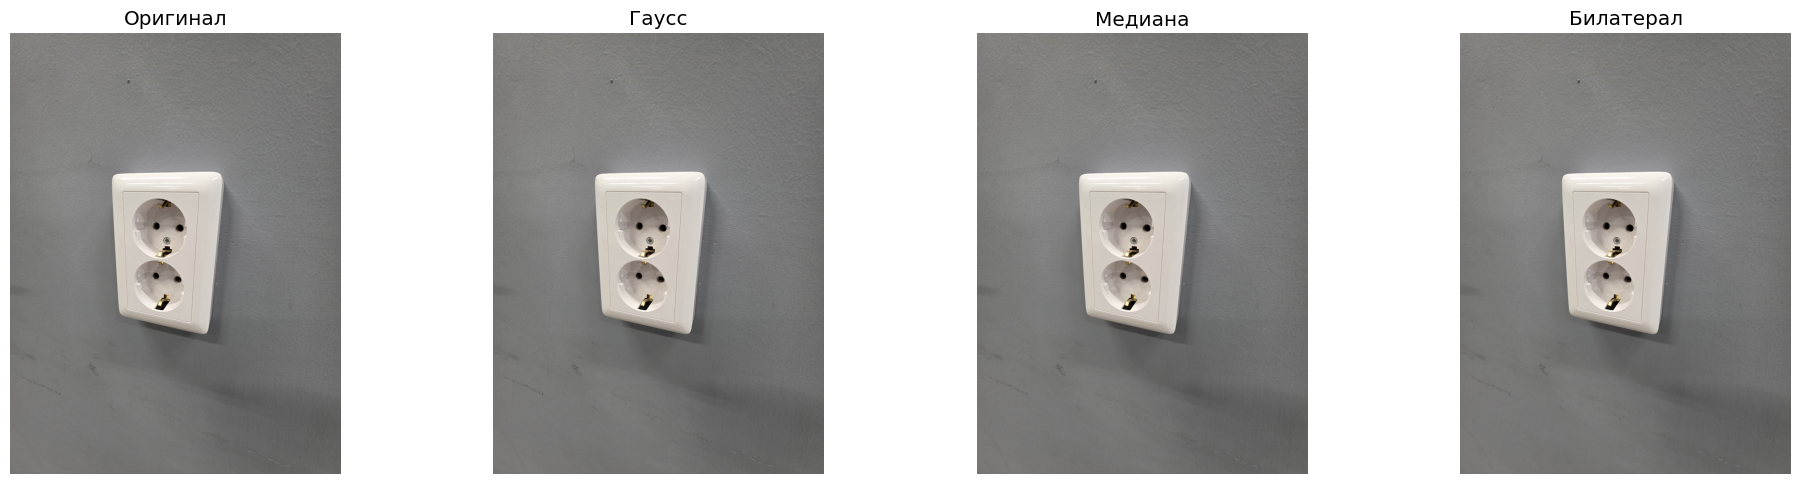

Шум убран


In [3]:
def apply_noise_reduction(img):
    gaussian = cv2.GaussianBlur(img, (5, 5), 0)
    median = cv2.medianBlur(img, 5)
    bilateral = cv2.bilateralFilter(img, 9, 75, 75)
    return gaussian, median, bilateral

img1_gauss, img1_median, img1_bilateral = apply_noise_reduction(img1_original)
img2_gauss, img2_median, img2_bilateral = apply_noise_reduction(img2_original)

show_images([img1_original, img1_gauss, img1_median, img1_bilateral], ['Оригинал', 'Гаусс', 'Медиана', 'Билатерал'], cols=4)

img1_denoised = img1_bilateral.copy()
img2_denoised = img2_bilateral.copy()

print("Шум убран")

## 4. Коррекция гистограммы

Применяем эквализацию гистограммы для улучшения контраста изображения.

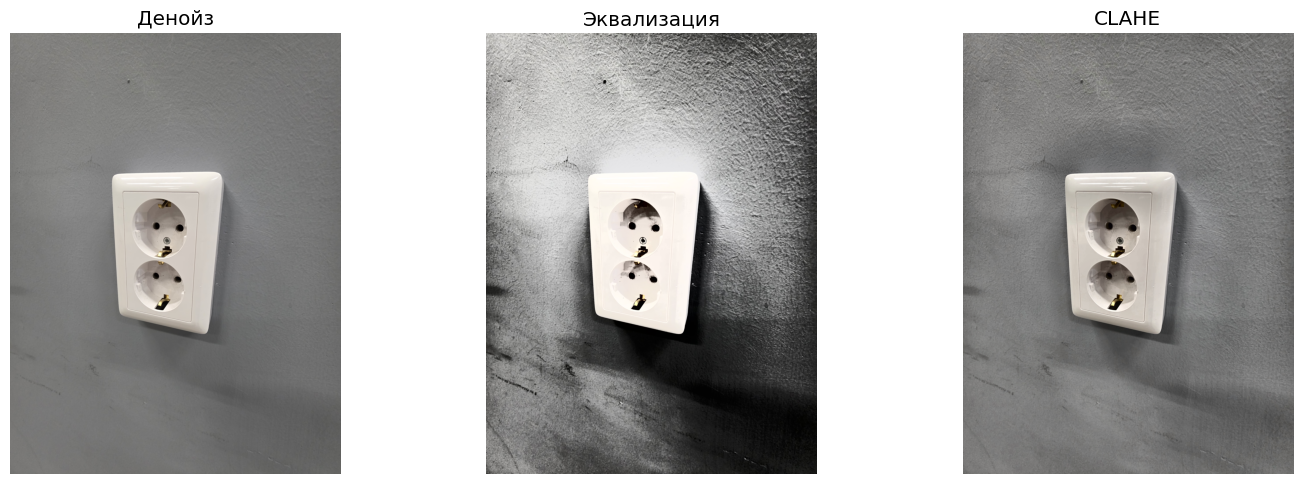

Гистограмма подправлена


In [4]:
def histogram_equalization(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    return cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

def adaptive_histogram_equalization(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

img1_hist_eq = histogram_equalization(img1_denoised)
img2_hist_eq = histogram_equalization(img2_denoised)
img1_clahe = adaptive_histogram_equalization(img1_denoised)
img2_clahe = adaptive_histogram_equalization(img2_denoised)

show_images([img1_denoised, img1_hist_eq, img1_clahe], ['Денойз', 'Эквализация', 'CLAHE'], cols=3)

img1_corrected = img1_clahe.copy()
img2_corrected = img2_clahe.copy()

print("Гистограмма подправлена")

## 5. Гамма-коррекция

Применяем гамма-коррекцию для настройки яркости изображения.

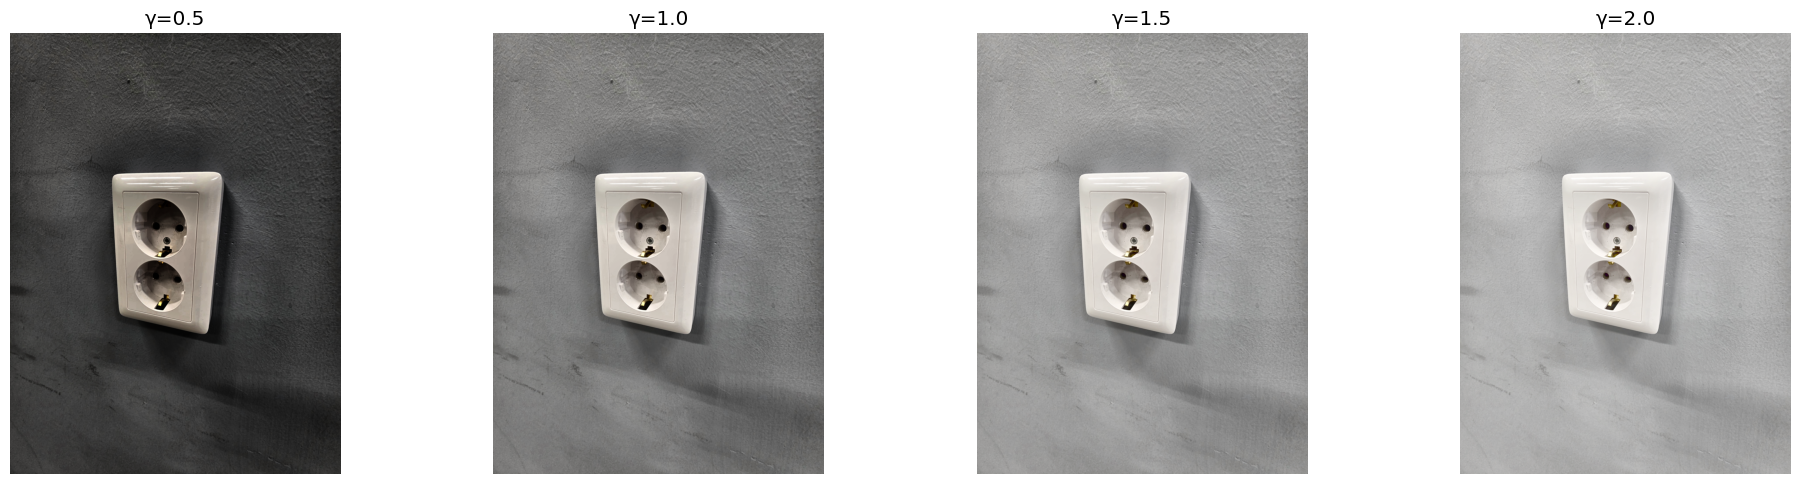

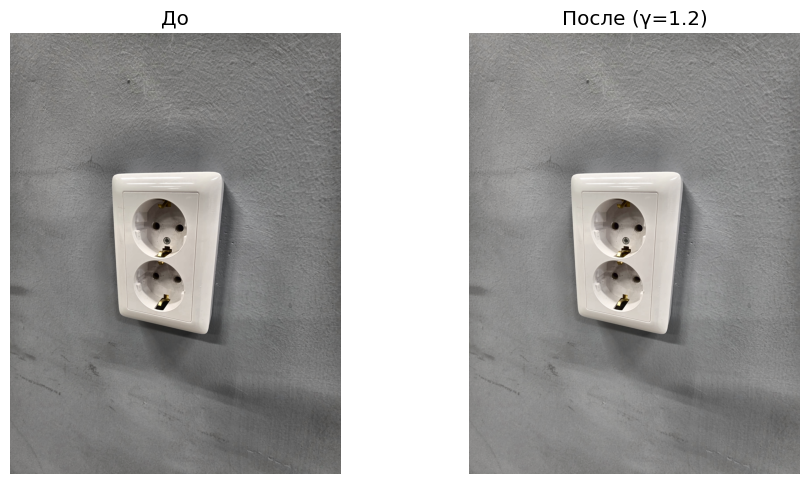

Гамма применена: γ=1.2


In [5]:
def adjust_gamma(image, gamma=1.0):
    """
    Применяет гамма-коррекцию к изображению
    gamma < 1: изображение становится ярче
    gamma > 1: изображение становится темнее
    gamma = 1: без изменений
    """
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

gamma_values = [0.5, 1.0, 1.5, 2.0]
gamma_images = [adjust_gamma(img1_corrected, g) for g in gamma_values]
gamma_titles = [f'γ={g}' for g in gamma_values]

show_images(gamma_images, gamma_titles, cols=4)

optimal_gamma = 1.2
img1_gamma = adjust_gamma(img1_corrected, optimal_gamma)
img2_gamma = adjust_gamma(img2_corrected, optimal_gamma)

show_images([img1_corrected, img1_gamma], ['До', f'После (γ={optimal_gamma})'], cols=2)

print(f"Гамма применена: γ={optimal_gamma}")

## 6. Калибровка камеры и коррекция геометрических искажений

### 6.1. Подготовка калибровочных изображений шахматной доски

Найдено 11 изображений
[1/11] chess1.heic... ✗
[2/11] chess10.heic... ✓


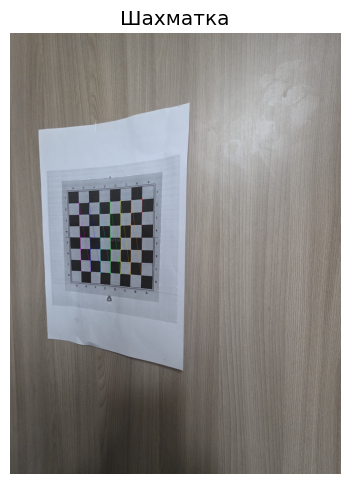

[3/11] chess11.heic... ✗
[4/11] chess2.heic... ✓
[5/11] chess3.heic... ✗
[6/11] chess4.heic... ✓
[7/11] chess5.heic... ✓
[8/11] chess6.heic... ✓
[9/11] chess7.heic... ✓
[10/11] chess8.heic... ✓
[11/11] chess9.heic... ✓

Успех: 8/11
Калибровка окончена (ошибка: 2.9850)

Матрица камеры:
[[1.62239821e+03 0.00000000e+00 1.54534602e+03]
 [0.00000000e+00 1.61909137e+03 2.03270344e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Дисторсия: [ 0.02491725  0.32381789  0.01665905  0.00196065 -0.37888991]
Дисторсия: подушкообразная (умеренная)


In [6]:
CHECKERBOARD = (7, 7)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

calibration_images_path = 'img/calibration/'

def get_calibration_images(base_path):
    base_dir = Path(base_path)
    if not base_dir.exists():
        return []
    exts = {'.jpg', '.jpeg', '.png', '.heic', '.heif'}
    return sorted([str(f) for f in base_dir.iterdir() if f.is_file() and f.suffix.lower() in exts])

def calibrate_camera(images_path):
    objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    objpoints = []
    imgpoints = []
    images = get_calibration_images(images_path)
    if not images:
        print("⚠ Калибровочные изображения не найдены!")
        print(f"Искал в: {os.path.abspath(images_path)}")
        print("Используем примерные параметры.")
        return None, None, None
    print(f"Найдено {len(images)} изображений")
    img_shape = None
    ok, bad = 0, []
    for i, fname in enumerate(images, 1):
        try:
            print(f"[{i}/{len(images)}] {os.path.basename(fname)}...", end=" ")
            img = load_image(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img_shape = gray.shape[::-1]
            ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
            if ret:
                objpoints.append(objp)
                corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
                imgpoints.append(corners2)
                ok += 1
                print("✓")
                if ok == 1:
                    show_images([cv2.drawChessboardCorners(img.copy(), CHECKERBOARD, corners2, ret)], ['Шахматка'], cols=1)
            else:
                bad.append(fname)
                print("✗")
        except Exception as e:
            bad.append(fname)
            print(f"✗ ({str(e)[:50]})")
    print(f"\nУспех: {ok}/{len(images)}")
    if ok < 3:
        print("Мало удачных — не калибруем")
        return None, None, None
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    print(f"Калибровка окончена (ошибка: {ret:.4f})")
    return mtx, dist, img_shape

camera_matrix, dist_coeffs, img_size = calibrate_camera(calibration_images_path)

if camera_matrix is not None:
    print("\nМатрица камеры:")
    print(camera_matrix)
    print("\nДисторсия:", dist_coeffs[0][:5])
    k1 = dist_coeffs[0][0]
    if k1 < -0.1:
        print("Дисторсия: бочкообразная (сильная)")
    elif k1 < 0:
        print("Дисторсия: бочкообразная (умеренная)")
    elif k1 > 0.1:
        print("Дисторсия: подушкообразная (сильная)")
    elif k1 > 0:
        print("Дисторсия: подушкообразная (умеренная)")
    else:
        print("Дисторсии почти нет")
else:
    h, w = img1_gamma.shape[:2]
    camera_matrix = np.array([[w, 0, w/2], [0, w, h/2], [0, 0, 1]], dtype=np.float32)
    dist_coeffs = np.array([[-0.3, 0.1, 0, 0, 0]], dtype=np.float32)

### 6.2. Применение коррекции дисторсии

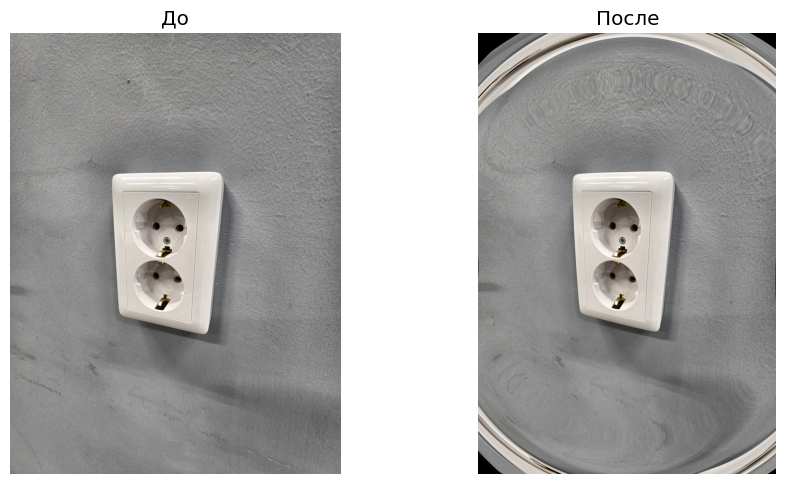

Дисторсия исправлена


In [7]:
def undistort_image(img, camera_matrix, dist_coeffs):
    h, w = img.shape[:2]
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))
    undistorted = cv2.undistort(img, camera_matrix, dist_coeffs, None, new_camera_matrix)
    x, y, w, h = roi
    if w > 0 and h > 0:
        undistorted = undistorted[y:y+h, x:x+w]
    return undistorted

img1_undistorted = undistort_image(img1_gamma, camera_matrix, dist_coeffs)
img2_undistorted = undistort_image(img2_gamma, camera_matrix, dist_coeffs)

show_images([img1_gamma, img1_undistorted], ['До', 'После'], cols=2)

print("Дисторсия исправлена")

## 7. Поиск ключевых точек

Используем различные алгоритмы поиска ключевых точек и выбираем топ-200.

SIFT:  200 / 200 точек
ORB:   200 / 200 точек
AKAZE: 200 / 200 точек


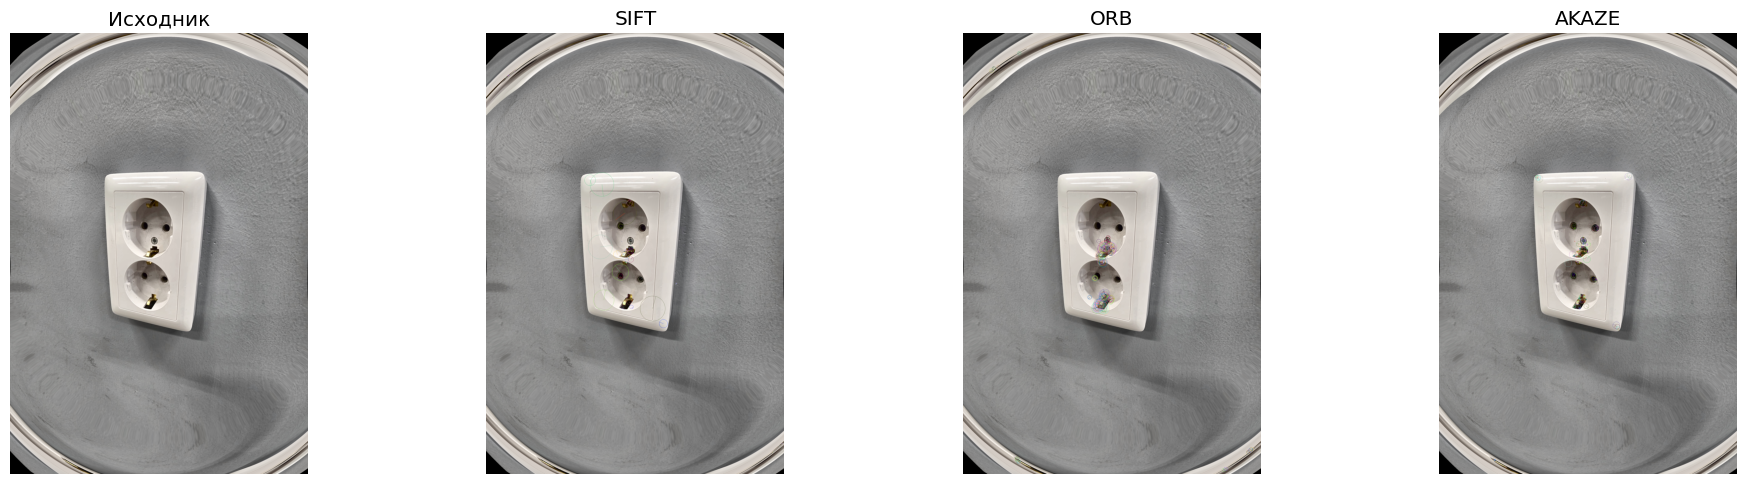

Ключевые точки найдены


In [8]:
def detect_keypoints_sift(img, n=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(nfeatures=n)
    return sift.detectAndCompute(gray, None)

def detect_keypoints_orb(img, n=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(nfeatures=n)
    return orb.detectAndCompute(gray, None)

def detect_keypoints_akaze(img, n=200):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    akaze = cv2.AKAZE_create()
    kp, desc = akaze.detectAndCompute(gray, None)
    if kp is not None and len(kp) > n:
        idx = np.argsort([-k.response for k in kp])[:n]
        kp = [kp[i] for i in idx]
        desc = desc[idx]
    return kp if kp is not None else [], desc if desc is not None else np.array([])

# Детектирование
kp1_sift, desc1_sift = detect_keypoints_sift(img1_undistorted, 200)
kp2_sift, desc2_sift = detect_keypoints_sift(img2_undistorted, 200)
kp1_orb,  desc1_orb  = detect_keypoints_orb(img1_undistorted, 200)
kp2_orb,  desc2_orb  = detect_keypoints_orb(img2_undistorted, 200)
kp1_akaze, desc1_akaze = detect_keypoints_akaze(img1_undistorted, 200)
kp2_akaze, desc2_akaze = detect_keypoints_akaze(img2_undistorted, 200)

print(f"SIFT:  {len(kp1_sift):3d} / {len(kp2_sift):3d} точек")
print(f"ORB:   {len(kp1_orb):3d} / {len(kp2_orb):3d} точек")
print(f"AKAZE: {len(kp1_akaze):3d} / {len(kp2_akaze):3d} точек")

# Визуализация (только для первого изображения)
img_sift  = cv2.drawKeypoints(img1_undistorted, kp1_sift,  None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_orb   = cv2.drawKeypoints(img1_undistorted, kp1_orb,   None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_akaze = cv2.drawKeypoints(img1_undistorted, kp1_akaze, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

show_images([img1_undistorted, img_sift, img_orb, img_akaze], ['Исходник', 'SIFT', 'ORB', 'AKAZE'], cols=4)

print("Ключевые точки найдены")

## 8. Сопоставление ключевых точек

Применяем различные методы сопоставления и фильтрацию для достижения точности >95%.

In [9]:
def match_keypoints_bf(desc1, desc2, norm_type, ratio=0.75):
    bf = cv2.BFMatcher(norm_type, crossCheck=False)
    matches = bf.knnMatch(desc1, desc2, k=2)
    good = []
    for m in matches:
        if len(m) == 2 and m[0].distance < ratio * m[1].distance:
            good.append(m[0])
    return good

def match_keypoints_sym(desc1, desc2, norm_type, ratio=0.7):
    bf = cv2.BFMatcher(norm_type)
    matches_12 = bf.knnMatch(desc1, desc2, k=2)
    matches_21 = bf.knnMatch(desc2, desc1, k=2)
    good_12 = {}
    for m, n in matches_12:
        if m.distance < ratio * n.distance:
            good_12[m.queryIdx] = m.trainIdx
    good_21 = {}
    for m, n in matches_21:
        if m.distance < ratio * n.distance:
            good_21[m.queryIdx] = m.trainIdx
    mutual = []
    for idx1, idx2 in good_12.items():
        if idx2 in good_21 and good_21[idx2] == idx1:
            mutual.append(cv2.DMatch(idx1, idx2, 0.0))
    return mutual

def match_keypoints_flann(desc1, desc2, norm_type, ratio=0.75):
    if norm_type == cv2.NORM_HAMMING:
        index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)  # For ORB
        search_params = dict(checks=50)
    else:  # NORM_L2 (SIFT, AKAZE)
        index_params = dict(algorithm=1, trees=5)
        search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)
    good = []
    for m in matches:
        if len(m) == 2 and m[0].distance < ratio * m[1].distance:
            good.append(m[0])
    return good

def filter_ransac(kp1, kp2, matches, thresh=5.0):
    if len(matches) < 4:
        return matches, None
    src = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src, dst, cv2.RANSAC, thresh, maxIters=5000, confidence=0.999)
    if mask is None:
        return matches, None
    return [matches[i] for i in range(len(matches)) if mask[i]], M

# Определяем детекторы и их параметры
detectors = [
    ('SIFT',  kp1_sift,  kp2_sift,  desc1_sift,  desc2_sift,  cv2.NORM_L2),
    ('ORB',   kp1_orb,   kp2_orb,   desc1_orb,   desc2_orb,   cv2.NORM_HAMMING),
    ('AKAZE', kp1_akaze, kp2_akaze, desc1_akaze, desc2_akaze, cv2.NORM_HAMMING if desc1_akaze.dtype == np.uint8 else cv2.NORM_L2)
]

best_overall = None
all_results = []

for name_det, kp1, kp2, desc1, desc2, norm in detectors:
    if desc1 is None or desc2 is None or len(desc1) == 0 or len(desc2) == 0:
        continue
    strategies = [
        ('BF 0.6',  lambda d1,d2: match_keypoints_bf(d1,d2, norm, 0.6),  3.0),
        ('BF 0.7',  lambda d1,d2: match_keypoints_bf(d1,d2, norm, 0.7),  4.0),
        ('Sym 0.6', lambda d1,d2: match_keypoints_sym(d1,d2, norm, 0.6), 3.0),
        ('Sym 0.7', lambda d1,d2: match_keypoints_sym(d1,d2, norm, 0.7), 4.0),
        ('FLANN',   lambda d1,d2: match_keypoints_flann(d1,d2, norm, 0.7), 4.0)
    ]
    for name_strat, func, ransac_t in strategies:
        try:
            matches = func(desc1, desc2)
            if not matches:
                continue
            inliers, H = filter_ransac(kp1, kp2, matches, ransac_t)
            fpr = (len(matches) - len(inliers)) / len(matches) * 100 if matches else 100
            res = {
                'detector': name_det,
                'strategy': name_strat,
                'fpr': fpr,
                'inliers': len(inliers),
                'matches': inliers,
                'homography': H,
                'kp1': kp1,
                'kp2': kp2
            }
            all_results.append(res)
            if fpr <= 5 and len(inliers) >= 4:
                if best_overall is None or len(inliers) > best_overall['inliers']:
                    best_overall = res
        except Exception as e:
            continue

if best_overall is None and all_results:
    valid = [r for r in all_results if r['inliers'] >= 4]
    if valid:
        best_overall = min(valid, key=lambda x: x['fpr'])
    else:
        best_overall = max(all_results, key=lambda x: x['inliers'])

if best_overall:
    good_matches_sift = best_overall['matches']
    homography = best_overall['homography']
    error_rate = best_overall['fpr']
    kp1_sift, kp2_sift = best_overall['kp1'], best_overall['kp2']
    method_name = f"{best_overall['detector']} + {best_overall['strategy']}"
    print(f"Лучший метод: {method_name}")
    print(f"Ошибки: {error_rate:.2f}%, надёжных совпадений: {len(good_matches_sift)}")
    if error_rate <= 5:
        print("OK: <=5% ошибок")
    else:
        print(">5% ошибок, но есть совпадения")
else:
    good_matches_sift = []
    homography = None
    error_rate = 100
    print("Совпадений не найдено ни одним методом")

Лучший метод: SIFT + Sym 0.7
Ошибки: 0.00%, надёжных совпадений: 4
OK: <=5% ошибок


## 9. Визуализация результатов сопоставления

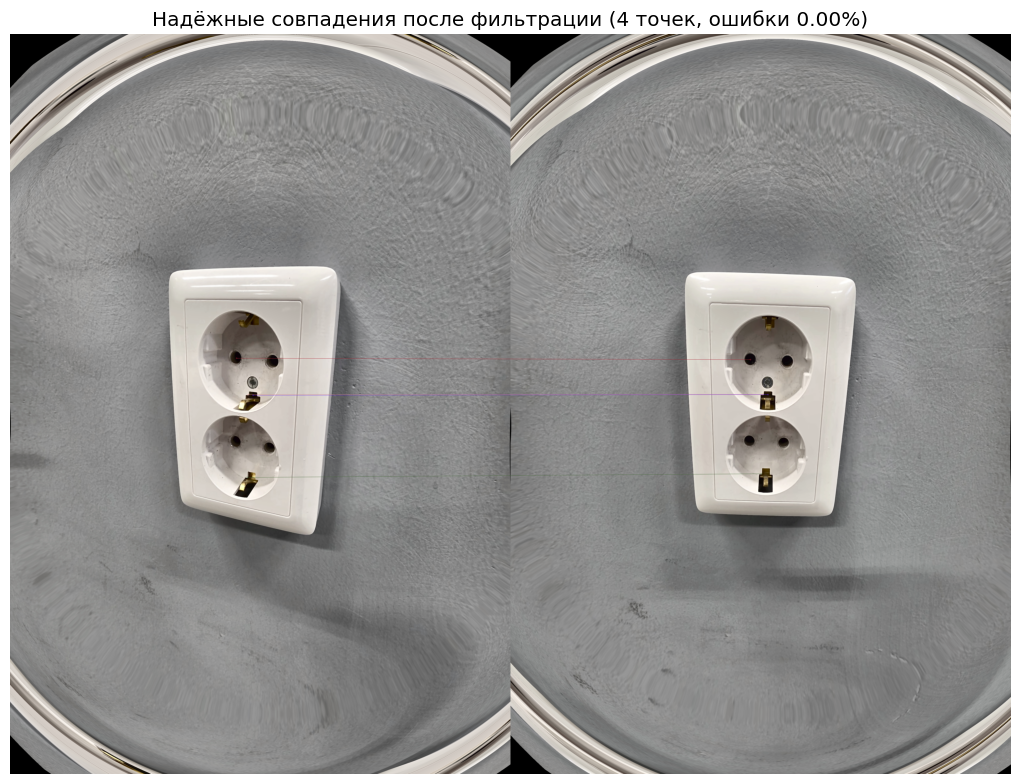

Визуализация совпадений готова


In [10]:
if len(good_matches_sift) > 0:
    img_matches = cv2.drawMatches(
        img1_undistorted, kp1_sift,
        img2_undistorted, kp2_sift,
        good_matches_sift, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(f'Надёжные совпадения после фильтрации ({len(good_matches_sift)} точек, ошибки {error_rate:.2f}%)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("Визуализация совпадений готова")
else:
    print("Нет совпадений для визуализации")

## 10. Применение гомографии для выравнивания изображений

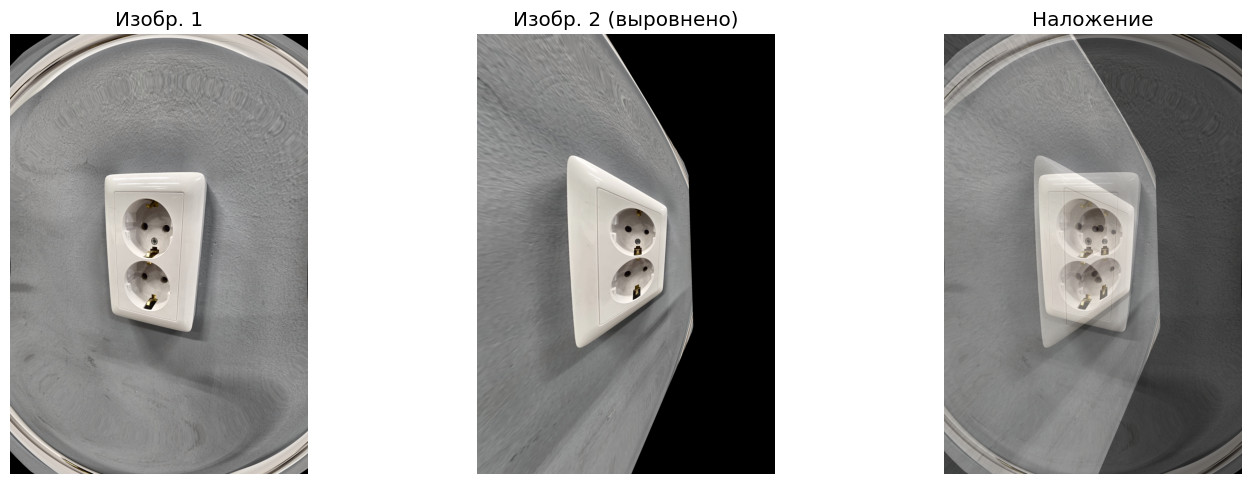

Выравнивание выполнено


In [11]:
if homography is not None and len(good_matches_sift) >= 4:
    h, w = img1_undistorted.shape[:2]
    img2_aligned = cv2.warpPerspective(img2_undistorted, homography, (w, h))
    if img2_aligned.any():
        overlay = cv2.addWeighted(img1_undistorted, 0.5, img2_aligned, 0.5, 0)
        show_images([img1_undistorted, img2_aligned, overlay], ['Изобр. 1', 'Изобр. 2 (выровнено)', 'Наложение'], cols=3)
        print("Выравнивание выполнено")
    else:
        print("Выровненное изображение пустое — гомография некорректна")
        img2_aligned = img2_undistorted.copy()
else:
    print("Гомография недоступна — недостаточно надёжных совпадений")
    img2_aligned = img2_undistorted.copy()

## 11. Сводка результатов

In [12]:
print("СВОДКА РЕЗУЛЬТАТОВ ЛАБОРАТОРНОЙ РАБОТЫ")

print("\n1. ПРЕДОБРАБОТКА:")
print("   ✓ Шум — убран (билатерал)")
print("   ✓ Гистограмма — CLAHE")
print(f"   ✓ Гамма — {optimal_gamma}")

print("\n2. КАЛИБРОВКА:")
if camera_matrix is not None:
    print("   ✓ Успешна")
    print("   ✓ Дисторсия исправлена")
else:
    print("   ! Параметры — по умолчанию")

print("\n3. КЛЮЧЕВЫЕ ТОЧКИ:")
print(f"   ✓ SIFT:  {len(kp1_sift):3d} / {len(kp2_sift):3d}")
print(f"   ✓ ORB:   {len(kp1_orb):3d} / {len(kp2_orb):3d}")
print(f"   ✓ AKAZE: {len(kp1_akaze):3d} / {len(kp2_akaze):3d}")

print("\n4. СОПОСТАВЛЕНИЕ:")
print(f"   ✓ Надёжных совпадений: {len(good_matches_sift)}")
print(f"   ✓ Процент ошибок: {error_rate:.2f}%")

if error_rate <= 5.0:
    print("\n   ✓✓✓ Требование выполнено: ошибок ≤ 5% ✓✓✓")
else:
    print(f"\n   ✗ Ошибок ({error_rate:.2f}%) > 5%")
    if len(good_matches_sift) >= 4:
        print("      → Гомография построена, выравнивание возможно")
    else:
        print("      → Недостаточно совпадений для выравнивания")

СВОДКА РЕЗУЛЬТАТОВ ЛАБОРАТОРНОЙ РАБОТЫ

1. ПРЕДОБРАБОТКА:
   ✓ Шум — убран (билатерал)
   ✓ Гистограмма — CLAHE
   ✓ Гамма — 1.2

2. КАЛИБРОВКА:
   ✓ Успешна
   ✓ Дисторсия исправлена

3. КЛЮЧЕВЫЕ ТОЧКИ:
   ✓ SIFT:  200 / 200
   ✓ ORB:   200 / 200
   ✓ AKAZE: 200 / 200

4. СОПОСТАВЛЕНИЕ:
   ✓ Надёжных совпадений: 4
   ✓ Процент ошибок: 0.00%

   ✓✓✓ Требование выполнено: ошибок ≤ 5% ✓✓✓
